# Analysis of Gene Expression Variability by Class
This notebook analyzes the variability of genes within classes.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest
from common_python.plots import util_plots as common_plots

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

trinary_short = TrinaryData()
trinary_short.df_X.columns = trinary_short.features
trinary_long = TrinaryData(is_averaged=False, is_dropT1=False)
trinary_long.df_X.columns = trinary_long.features

%matplotlib inline

In [2]:
trinary_long.df_X.head()

,Rv1131,Rv1927,Rv3085,Rv3083,Rv2642,Rv3741c,Rv0841,Rv1129c,Rv3086,Rv0260c,...,Rv3267,Rv0288,Rv0129c,Rv3135,Rv0351,Rv2147c,Rv2737c,Rv0440,Rv3269,Rv3418c
T1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
trinary_long.ser_y.head()

T1.0    0
T1.1    0
T1.2    0
T2.0    1
T2.1    1
Name: name, dtype: int64

## F-Stat by Gene

In [4]:
CLASS = "class"
df_ext = trinary_long.df_X
df_ext[CLASS] = trinary_long.ser_y

In [5]:
dfg = df_ext.groupby(CLASS)
dfg_std = dfg.std()
dfg_mean = dfg.mean()
dfg_count = dfg.count()
dfg_count.head()

,Rv1131,Rv1927,Rv3085,Rv3083,Rv2642,Rv3741c,Rv0841,Rv1129c,Rv3086,Rv0260c,...,Rv3267,Rv0288,Rv0129c,Rv3135,Rv0351,Rv2147c,Rv2737c,Rv0440,Rv3269,Rv3418c
class,,,,,,,,,,,,,,,,,,,,,
0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
2,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
3,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
4,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [6]:
dfg_mean.head()

,Rv1131,Rv1927,Rv3085,Rv3083,Rv2642,Rv3741c,Rv0841,Rv1129c,Rv3086,Rv0260c,...,Rv3267,Rv0288,Rv0129c,Rv3135,Rv0351,Rv2147c,Rv2737c,Rv0440,Rv3269,Rv3418c
class,,,,,,,,,,,,,,,,,,,,,
0,-1.0,-1.000000,-1.000000,-1.000000,-0.333333,-0.666667,-0.333333,-1.000000,-1.000000,-0.666667,...,0.666667,0.333333,0.333333,0.333333,1.000000,0.333333,1.000000,1.000000,1.000000,1.000000
1,-1.0,-1.000000,-1.000000,-1.000000,-0.666667,-0.833333,-0.722222,-1.000000,-1.000000,-1.000000,...,0.666667,0.777778,0.944444,0.944444,0.666667,0.888889,0.944444,1.000000,1.000000,1.000000
2,-1.0,-0.611111,-0.777778,-0.944444,-0.166667,-0.722222,-0.666667,-0.555556,-0.388889,-0.277778,...,0.000000,-0.333333,-0.166667,-0.055556,-0.111111,-0.166667,0.222222,0.388889,0.611111,0.333333
3,-1.0,-1.000000,-1.000000,-0.866667,-0.733333,-0.733333,-0.400000,-1.000000,-0.866667,-1.000000,...,0.400000,0.933333,0.933333,0.600000,0.733333,0.933333,1.000000,1.000000,1.000000,1.000000
4,-1.0,-1.000000,-0.777778,-0.222222,0.000000,-1.000000,-0.111111,-1.000000,0.000000,0.000000,...,-0.111111,-0.333333,0.000000,0.444444,0.333333,0.333333,0.888889,1.000000,1.000000,0.888889


In [8]:
ser_mean = trinary_long.df_X.mean()
del ser_mean[CLASS]
#df_ssb = dfg_count*(dfg_mean - ser_mean)**2
df_ssb = dfg_count*(dfg_mean - ser_mean)**2
ser_ssb = df_ssb.sum()
ser_ssb

Rv1131      0.280000
Rv1927      2.068889
Rv3085      0.853333
Rv3083      4.433333
Rv2642      6.530000
             ...    
Rv2147c    17.205556
Rv2737c    11.418889
Rv0440      5.108889
Rv3269      2.068889
Rv3418c     5.857778
Length: 2342, dtype: float64

In [9]:
# Calculate the sum of squares within
df_ssw = dfg_std*(dfg_count - 1)
ser_ssw = df_ssw.sum()
ser_ssw

Rv1131      4.281744
Rv1927      8.527733
Rv3085     10.800143
Rv3083     12.460728
Rv2642     29.496564
             ...    
Rv2147c    27.954284
Rv2737c    17.121506
Rv0440      8.527733
Rv3269      8.527733
Rv3418c    14.328570
Length: 2342, dtype: float64

(array([369., 374., 478., 388., 269., 160., 121.,  71.,  48.,  37.,  15.,
          5.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   2.]),
 array([0.        , 0.12231561, 0.24463122, 0.36694682, 0.48926243,
        0.61157804, 0.73389365, 0.85620926, 0.97852487, 1.10084047,
        1.22315608, 1.34547169, 1.4677873 , 1.59010291, 1.71241852,
        1.83473412, 1.95704973, 2.07936534, 2.20168095, 2.32399656,
        2.44631217]),
 <a list of 20 Patch objects>)

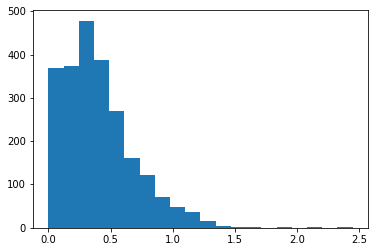

In [11]:
ser_fstat = ser_ssb/ser_ssw
plt.hist(ser_fstat, bins=20)

In [16]:
ser_fstat = ser_fstat.sort_values(ascending=False)
ser_fstat[ser_fstat.index[0:15]]

Rv0676c--Rv2829c    2.446312
Rv2698              2.446312
Rv2627c             2.097279
Rv1997              1.875959
Rv0241c             1.614771
Rv2626c             1.502922
Rv2005c             1.389839
Rv0602c             1.371179
Rv0591              1.364046
Rv1477              1.359965
Rv0976c             1.359327
Rv0629c             1.345309
Rv2573              1.330304
Rv0601c             1.328548
Rv3450c             1.324059
dtype: float64